# 학습내용

[1] 이진분류 개요

[2] 분류 평가지표

[3] 심층신경망 구현 (이진분류)

[4] 다진분류 개요

[5] 심층신경망 구현 (다진분류)

# [1] 이진분류 개요

- 출력단에 활성화 함수로 Simoid 함수를 적용
- 기준값 이상이면 1, 이하이면 0으로 판별

<center>  
<img src="https://arome1004.cafe24.com/images/pytorch/lecture_image/06_binary_classification_overview.png" width=60%>   
</center>  

# [2] 분류 평가지표

- 이진 분류는 정답이 2가지 클래스 중에 하나에 속함
- 분류결과는 4가지 유형으로 나타남
  - Negative로 Negative로 예측 (TN - True Negative)
  - Negative로 Positive를 예측 (FP - Flase Positive)
  - Positive를 Negative로 예측 (FN - False Negative)
  - Positive를 Positive로 예측 (TP - True Positive)

<center>  
<img src="https://arome1004.cafe24.com/images/pytorch/lecture_image/06_confusion_matrix.png" width=40%>   
</center>  



## 정확도 (Accuracy)
- 전체 예측값 중에서 정확히 맞춘 비율

<center>  
<img src="https://arome1004.cafe24.com/images/pytorch/lecture_image/06_accuracy.png" width=30%>   
</center>  

## 재현율 (Recall)
- 실제 Positive 중에서 예측한 Positive의 비율

<center>  
<img src="https://arome1004.cafe24.com/images/pytorch/lecture_image/06_recall.png" width=30%>   
</center>  


## 정밀도 (Precision)
- 예측한 Positive 중에서 실제 Positive의 비율

<center>  
<img src="https://arome1004.cafe24.com/images/pytorch/lecture_image/06_precision.png" width=30%>   
</center>  



## F1 스코어
- 정밀도와 재현율의 조화평균

<center>  
<img src="https://arome1004.cafe24.com/images/pytorch/lecture_image/06_f1score.png" width=30%>   
</center>  

- scikit-learn 라이브러리 이용

In [1]:
from sklearn.metrics import classification_report

In [2]:
# 샘플데이터
y = ['음치','음치','음치','음치','가수','가수']
pred_y = ['음치','음치','가수','가수','가수','음치']

In [3]:
print(classification_report(y,pred_y))

              precision    recall  f1-score   support

          가수       0.33      0.50      0.40         2
          음치       0.67      0.50      0.57         4

    accuracy                           0.50         6
   macro avg       0.50      0.50      0.49         6
weighted avg       0.56      0.50      0.51         6



- <font color=red>nn.BCELoss() 클래스</font> (이진 교차 엔트로피 오차)
  -  <font color=red>F.binary_cross_entropy()</font>를 이용하여 손실값을 계산하는 함수
  - BCELoss()는 클래스이며 binary_cross_entropy()는 함수 형태

  - t : 실제값 (불연속적인 실제값)
  - y : 예측값 (pred_y) (연속적인 sigmoid 출력값)

<center>  
<img src="https://arome1004.cafe24.com/images/pytorch/lecture_image/06_bceloss.png" width=50%>   
</center>  

<center>  
<img src="https://arome1004.cafe24.com/images/pytorch/lecture_image/06_bceloss2.png" width=60%>   
</center>  

# [3] 심층신경망 구현 (이진분류)

- 라이브러리 등록

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from copy import deepcopy

from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

- 데이터 준비
  - wisconsin의 유방암 데이터셋
  - 총 569건의 데이터 (악성(212), 양성 (357)으로 구성)

<center>  
<img src="https://arome1004.cafe24.com/images/pytorch/lecture_image/06_breast_cansor.png" width=30%>   
</center>  



In [5]:
# 데이터로딩
cansor = load_breast_cancer()

df = pd.DataFrame(cansor.data, # 특성데이터
                  columns = cansor.feature_names) # 특성이름
df['class'] = cansor.target # 정답데이터 추가
df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,class
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


- 특성데이터와 라벨데이터로 분리
- 데이터를 랜덤으로 섞고 훈련데이터, 검증데이터, 테스트 데이터로 분리

In [6]:
data = torch.from_numpy(df.values).float()

# 문제와 정답으로 분리(슬라이싱)
X = data[:, :-1] # 정답부분 제외
y = data[:,-1].unsqueeze(1) # 정답부분 추출 -> 차원증가

In [7]:
y.size()

torch.Size([569, 1])

In [8]:
y

tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
      

In [9]:
# 훈련,검증,평가 데이터로 분리
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=1146)

In [10]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train,y_train, test_size=0.2, random_state=1146)

In [11]:
print('train : ', X_train.size(), y_train.size())
print('valid : ', X_valid.size(), y_valid.size())
print('test : ', X_test.size(), y_test.size())

train :  torch.Size([364, 30]) torch.Size([364, 1])
valid :  torch.Size([91, 30]) torch.Size([91, 1])
test :  torch.Size([114, 30]) torch.Size([114, 1])


- 스케일링

In [12]:
scaler = StandardScaler()
scaler.fit(X_train) # 훈련용 데이터를 기준으로 스케일링 기준 탐색

StandardScaler()

In [13]:
X_train = torch.from_numpy(scaler.transform(X_train)).float()

In [14]:
X_valid = torch.from_numpy(scaler.transform(X_valid)).float()

In [15]:
X_test = torch.from_numpy(scaler.transform(X_test)).float()

In [16]:
X_train

tensor([[-0.1651,  1.2603, -0.1863,  ...,  0.2945,  0.9603, -0.2273],
        [-0.7220,  1.2135, -0.7312,  ..., -0.9952,  0.5835, -0.8661],
        [ 1.0261,  0.4020,  1.2895,  ...,  1.2608,  0.5851,  2.0290],
        ...,
        [-0.4255, -0.4680, -0.4485,  ..., -0.8754, -0.3436, -0.7870],
        [ 0.9818,  2.0414,  1.0036,  ...,  1.2699,  0.1299,  0.4225],
        [ 0.1839, -0.6154,  0.2520,  ...,  1.3566,  1.1520,  1.2935]])

- 신경망 설계

In [17]:
# 클래스 정의
class BinaryModel(nn.Module) :
  # 생성자
  def __init__(self, input_dim, output_dim) :
    super().__init__() # 상속받은 부모 클래스 생성
    # 입출력 차원정보를 인스턴스 변수로 저장
    self.input_dim = input_dim
    self.output_dim = output_dim
    self.linear1 = nn.Linear(input_dim,32)
    self.linear2 = nn.Linear(32,64)
    self.linear3 = nn.Linear(64,128)
    self.linear4 = nn.Linear(128,64)
    self.linear5 = nn.Linear(64,32)
    self.linear6 = nn.Linear(32,output_dim)
    self.act_relu = nn.ReLU()
    self.act_sigmoid = nn.Sigmoid()
  # 순전파(추론) 함수
  def forward(self,x) :
    h = self.act_relu(self.linear1(x))
    h = self.act_relu(self.linear2(h))
    h = self.act_relu(self.linear3(h))
    h = self.act_relu(self.linear4(h))
    h = self.act_relu(self.linear5(h))
    h = self.act_sigmoid(self.linear6(h))

    return h

In [18]:
X_train.size()

torch.Size([364, 30])

In [19]:
y_train.size()

torch.Size([364, 1])

In [20]:
# 모델생성
model1 = BinaryModel(X_train.size(1), y_train.size(1))

In [21]:
# 최적화 도구 설정
optimizer = optim.Adam(model1.parameters(), lr=0.001)

- 학습 파라미터 설정

In [22]:
n_epochs = 300
batch_size = 32
print_interval = 10
early_stop = 100
lowest_loss = np.inf
best_model = None
lowest_epoch = np.inf

- 신경망 학습 구현 (이진 분류)

In [23]:
train_history, valid_history = [], [] # 훈련loss와 검증loss를 기록할 리스트 생성

for epoch in range(n_epochs) :
  # 배치사이즈 만큼 데이터 분할
  ## 모델 일반화를 위한 데이터 셔플
  idx = torch.randperm(X_train.size(0))
  X_train = torch.index_select(X_train, dim=0, index=idx)
  y_train = torch.index_select(y_train, dim=0, index=idx)
  ## 32개씩 데이터를 묶어서 리스트로 만들기
  X_train_batch = X_train.split(batch_size, dim=0)
  y_train_batch = y_train.split(batch_size, dim=0)

  # 매 epoch의 loss값을 저장하는 변수
  train_loss, valid_loss = 0,0

  # 매 epoch마다 batch 데이터 묶음 만큼 반복
  for x, y in zip(X_train_batch, y_train_batch) :
    # 순전파(추론)
    pred_y = model1(x)
    # 이진분류용 손실함수 사용
    loss = F.binary_cross_entropy(pred_y, y)
    # 모델최적화
    optimizer.zero_grad() # 모든 기울기 값을 0으로 초기화
    # 기울기 계산(편미분)
    loss.backward()
    # 파라미터 업데이트(가중치,절편)
    optimizer.step()

    train_loss += loss.item() # 각 배치사이즈 만큼의 loss값을 누적

  # 누적된 loss를 평균내어 1 epoch에 대한 loss로 변환 -> history 변수에 누적
  train_history.append(train_loss / len(X_train_batch))

  # 검증데이터 loss 계산
  with torch.no_grad() : # 계산그래프 구성 x, 계산의 속도 향상
    # 배치사이즈만큼 쪼개서 리스트로 구성
    X_valid_batch = X_valid.split(batch_size, dim=0)
    y_valid_batch = y_valid.split(batch_size, dim=0)

    for x,y in zip(X_valid_batch,y_valid_batch) :
      pred_y = model1(x) # 모델추론
      loss = F.binary_cross_entropy(pred_y,y) # 손실값 계산
      valid_loss += loss # 매 배치로부터 나오는 loss값 누적
    # 1 epoch에 대한 loss 계산후 history에 추가
    valid_history.append(valid_loss / len(X_valid_batch))

  # 학습과정 log출력
  print(f"epoch : {epoch}, train_loss : {train_history[-1]}, valid_loss : {valid_history[-1]}")

epoch : 0, train_loss : 0.6883595734834671, valid_loss : 0.659548819065094
epoch : 1, train_loss : 0.6035003066062927, valid_loss : 0.48857536911964417
epoch : 2, train_loss : 0.33815469841162366, valid_loss : 0.15889717638492584
epoch : 3, train_loss : 0.12968002795241773, valid_loss : 0.07494723796844482
epoch : 4, train_loss : 0.08086169456752638, valid_loss : 0.08867555856704712
epoch : 5, train_loss : 0.06790890009142458, valid_loss : 0.1257110983133316
epoch : 6, train_loss : 0.05554866410481433, valid_loss : 0.130366250872612
epoch : 7, train_loss : 0.05105883538878212, valid_loss : 0.15429486334323883
epoch : 8, train_loss : 0.046708679369961224, valid_loss : 0.14094389975070953
epoch : 9, train_loss : 0.04083537927363068, valid_loss : 0.1913021057844162
epoch : 10, train_loss : 0.030370842781849205, valid_loss : 0.17284227907657623
epoch : 11, train_loss : 0.028844819889248658, valid_loss : 0.1872912049293518
epoch : 12, train_loss : 0.024782648930946987, valid_loss : 0.186809

- 손실곡선 확인

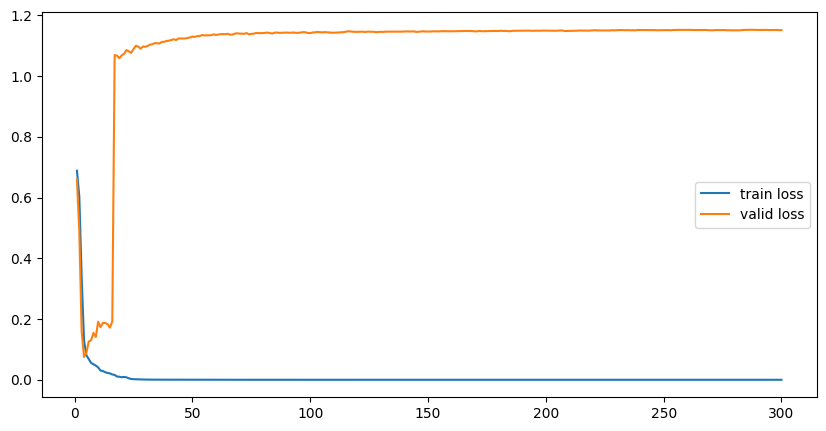

In [24]:
plt.figure(figsize=(10,5))
# 훈련용 손실
plt.plot(range(1,len(train_history)+1), # x축데이터 (epoch)
         train_history, # y축데이터 (loss)
         label='train loss')
# 검증용 손실
plt.plot(range(1,len(valid_history)+1), # x축데이터 (epoch)
         valid_history, # y축데이터 (loss)
         label='valid loss')
# 범례
plt.legend()
plt.show()

- 테스트 데이터로 모델 성능 평가

In [25]:
# 1. 변수 초기화
test_loss_total = 0 # 손실 누적값
predictions = []    # 배치별 예측결과 담아둘 리스트

In [26]:
batch_size

32

In [27]:
# 2. 평가 계산
with torch.no_grad() : # 기울기 계산 비활성화(메모리 절약, 속도 증가) → 검증, 평가, inference(추론) 등
  # 2-1. 배치 단위 분할
  X_test_batches = X_test.split(batch_size, dim = 0)
  y_test_batches = y_test.split(batch_size, dim = 0)

  # 2-2. 각 배치에 대해 순전파, 오차 계산
  for X_batch, y_batch in zip(X_test_batches, y_test_batches) :
    batch_pred = model1(X_batch) # 순전파
    batch_loss = F.binary_cross_entropy(batch_pred, y_batch) # 오차 계산
    test_loss_total += batch_loss.item() # float형
    predictions.append(batch_pred)

In [28]:
# 3. 테스트 셋에 대한 손실 계산
test_loss_total / len(X_test_batches)  # 총 손실 / 배치수

1.1004305685098714

In [29]:
# 최고 성능 에포크(검증용 데이터 기준) 때의 train/valid loss 값 확인
best_train_loss, best_valid_loss = sorted(zip(train_history, valid_history), key = lambda x: x[1])[0]

In [30]:
print(f"최고 성능 에포크 때의 train loss : {best_train_loss:.4f}") # 실수, 소수점 4자리
print(f"최고 성능 에포크 때의 valid loss : {best_valid_loss:.4f}") # 실수, 소수점 4자리

최고 성능 에포크 때의 train loss : 0.1297
최고 성능 에포크 때의 valid loss : 0.0749


- 정확도 계산

In [31]:
# 1. test set 배치 하나로 합치기
y_pred_tensor = torch.cat(predictions, dim = 0)

# 2. sigmoid에 의한 확률값(예측값) > 0.5 → 1, 그 외에는 0
y_pred_labels = (y_pred_tensor > 0.5).float()

# 3. 실제 라벨과 비교해서 맞춘 개수(TP, TN) 계산
correct_count = (y_pred_labels == y_test).sum().item()

# 4. 전체 샘플수
total_count = y_test.size(0)

# 5. 계산
correct_count / total_count

0.9473684210526315

# [4] 다중분류 개요
  - 다중분류는 정답 레이블이 다양한 클래스가 될 수 있음
  
  - 활성화 함수 : softmax 함수
    - Sigmoid 함수 : 클래스별로 확률 계산
    - Softmax 함수 : 전체 클래스 대비 대상 클래스의 확률 계산 (전체 확률합은 1이 됨)
      - 출력벡터는 입력이 어떤 클래스에 속할 것인지에 대한 조건부 확률 분포

  - 손실함수 : CrossEntropyLoss()
    > - CrossEntropyLoss() == LogSoftmax() + NLLLosss()

<center>  
<img src="https://arome1004.cafe24.com/images/pytorch/lecture_image/06_softmax.png" width=60%>   
</center>     

# [5] 심층 신경망 구현 (다중분류)

- MNIST 데이터셋
  - 0부터 9까지의 손글씨 숫자 흑백 이미지 데이터
    - 이미지는 0-255 범위의 픽셀값으로 구성
  - 훈련데이터 60,000개, 테스트데이터 10,000개로 구성
  - 라벨데이터는 0-9까지 10가지로 구성

<center>  
<img src="https://arome1004.cafe24.com/images/pytorch/lecture_image/06_mnist.png" width=30%>   
</center>     

- 라이브러리 등록

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from copy import deepcopy
from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import datasets, transforms
# datasets : 데이터 제공 도구
# transforms : 이미지 전처리 도구 (데이터 로드 시 활용)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

- 데이터 준비

In [33]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [34]:
%cd /content/drive/MyDrive/강의 자료들/2025/250701 인사교 6기 자연어처리 B반/딥러닝 기초 25.07.11 (class 2)

/content/drive/.shortcut-targets-by-id/1BetU2RLJA7gC3DgSstzRg0db8buEhQBE/딥러닝 기초 25.07.11 (class 2)


In [35]:
# 데이터셋 로드
train = datasets.MNIST(
    root = "./data",
    train = True,    # 변수에 train set을 할당할지에 대한 여부
    download = True, # 로컬에 데이터(train, test)가 없으면 다운로드
    transform = transforms.Compose([ # 여러개의 전처리를 순서대로 묶어서, 데이터를 로드할 때 처리하도록 지정하는 인자값
        transforms.ToTensor()        # tensor형으로 처리해서 로드
    ])
)

test = datasets.MNIST(
    root = "./data",
    train = False,
    download = False,
    transform = transforms.Compose([ # 여러개의 전처리를 순서대로 묶어서, 데이터를 로드할 때 처리하도록 지정하는 인자값
        transforms.ToTensor()        # tensor형으로 처리해서 로드
    ])
)

- 데이터 확인

In [36]:
train.data.shape

torch.Size([60000, 28, 28])

In [37]:
# 이미지 시각화 하는 함수
def ploting(x) :
    img = np.array(x.detach().cpu(), dtype = "float")
    plt.figure(figsize = (3, 3))
    plt.imshow(img, cmap = "gray")
    plt.axis("off")
    plt.show()

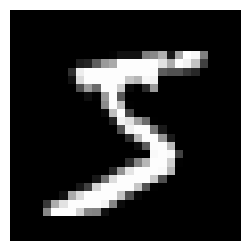

In [38]:
ploting(train.data[0])

In [39]:
train.targets[0]

tensor(5)

- 데이터 전처리
  - 0-255 범위의 픽셀값을 0.0-1.0 범위로 정규화
  - 2차원 데이터를 선형 신경망에 입력으로 하기 위해 1차원 데이터로 변환

In [40]:
# 0. ~ 1. 까지의 범위로 정규화
X_data = train.data.float() / 255.

y_data = train.targets

# test set도 동일하게 적용
X_test = test.data.float() / 255.

y_test = test.targets

In [41]:
X_data.shape, X_test.shape, y_data.shape, y_test.shape

(torch.Size([60000, 28, 28]),
 torch.Size([10000, 28, 28]),
 torch.Size([60000]),
 torch.Size([10000]))

- 신경망 입력과 출력 크기 설정

In [42]:
X_data = X_data.view(X_data.size(0), -1) # -1 : 나머지 차원에 대해 자동으로 계산
X_test = X_test.view(X_test.size(0), -1)

In [43]:
X_data.shape, X_test.shape

(torch.Size([60000, 784]), torch.Size([10000, 784]))

In [44]:
# 입력크기, 출력크기 세팅
input_size = X_data.size(-1)
output_size = max(y_data).item() + 1

In [45]:
input_size, output_size

(784, 10)

- 훈련데이터와 검증데이터 분리

In [46]:
X_train, X_valid, y_train, y_valid = train_test_split(X_data, y_data, test_size = 0.2, random_state = 2025, stratify = y_data)

In [47]:
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

(torch.Size([48000, 784]),
 torch.Size([12000, 784]),
 torch.Size([48000]),
 torch.Size([12000]))

- 신경망 설계

In [48]:
# 1. 클래스 정의
class CategoricalModel(nn.Module) :
    def __init__(self, input_dim, output_dim) :
        # 2. 생성자
        super().__init__()

        # 3. 인스턴스 변수(속성) 정의 - 레이어, 활성화 함수 등을 정의
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.linear1 = nn.Linear(input_dim, 500)
        self.linear2 = nn.Linear(500, 400)
        self.linear3 = nn.Linear(400, 300)
        self.linear4 = nn.Linear(300, 200)
        self.linear5 = nn.Linear(200, 100)
        self.linear6 = nn.Linear(100, 50)
        self.linear7 = nn.Linear(50, output_dim)
        self.act_relu = nn.ReLU()
#        self.act_logsoftmax = nn.LogSoftmax() # CrossEntropyLoss() 를 사용하고자 하는경우, 생략

    # 4. 순전파(forward) 메서드 정의
    def forward(self, x) :
        h = self.act_relu(self.linear1(x))
        h = self.act_relu(self.linear2(h))
        h = self.act_relu(self.linear3(h))
        h = self.act_relu(self.linear4(h))
        h = self.act_relu(self.linear5(h))
        h = self.act_relu(self.linear6(h))
        logits = self.linear7(h)
#        y = self.act_logsoftmax(self.linear7(h))
        return logits

In [49]:
model1 = CategoricalModel(input_size, output_size)

- GPU 사용 설정

In [50]:
# GPU 사용 가능 여부 설정
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [51]:
# 모델 이동(파라미터, 연산되는 요소들 등)
model1 = model1.to(device)

In [52]:
# 데이터 같이 이동 - 모델을 이동시켰으면, VRAM(GPU 메모리 공간)을 사용하기 때문에 데이터도 같이 이동

X_train = X_train.to(device)
X_valid = X_valid.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_valid = y_valid.to(device)
y_test = y_test.to(device)

- 최적화 함수 / 손실함수

In [55]:
learning_rate = 1e-3 # 0.001
optimizer1 = optim.Adam(model1.parameters(), lr = learning_rate)

In [56]:
# 현재 우리 클리스는 logit(확률분포, 1D 예측값 벡터) → CrossEntropyLoss == 소프트맥스 + 손실함수
loss_func = nn.CrossEntropyLoss()

- 학습 파라미터 설정

In [57]:
n_epohcs = 1000
batch_size = 256

print_interval = 10

lowest_loss = np.inf # 최저 검증 손실값
best_model = None    # 최저 검증 손실값을 가졌을 때 모델을 저장할 변수

early_stop = 50      # patience
lowest_epoch = np.inf # 최저 검증 손실값을 가졌을 때 에포크 번호

- 학습 구현

In [58]:
train_history, valid_history = [], []

model1.train() # 학습 모드 - 역전파 수행
# 보통 드롭아웃, 배치정규화 같이 모델 내부의 레이어들을 학습 전용 상태로 전환

CategoricalModel(
  (linear1): Linear(in_features=784, out_features=500, bias=True)
  (linear2): Linear(in_features=500, out_features=400, bias=True)
  (linear3): Linear(in_features=400, out_features=300, bias=True)
  (linear4): Linear(in_features=300, out_features=200, bias=True)
  (linear5): Linear(in_features=200, out_features=100, bias=True)
  (linear6): Linear(in_features=100, out_features=50, bias=True)
  (linear7): Linear(in_features=50, out_features=10, bias=True)
  (act_relu): ReLU()
)

In [59]:
# 학습 빈도수 기반으로 반복 - 학습 루프 생성
for epoch in tqdm(range(n_epohcs), desc="training"):
    # === [1] 셔플 및 배치 분할 ===
    idx = torch.randperm(X_train.size(0))  # 인덱스 무작위 셔플
    X_train = X_train[idx]
    y_train = y_train[idx]

    X_train_batches = X_train.split(batch_size, dim=0)
    y_train_batches = y_train.split(batch_size, dim=0)

    train_loss, valid_loss = 0.0, 0.0

    # === [2] 훈련 단계 ===
    model1.train()  # 학습 모드
    for X_batch, y_batch in zip(X_train_batches, y_train_batches):
        optimizer1.zero_grad()  # 기울기 초기화

        output = model1(X_batch)  # 순전파
        loss = loss_func(output, y_batch)  # 손실 계산

        loss.backward()  # 역전파
        optimizer1.step()  # 파라미터 업데이트

        train_loss += loss.item()

    # === [3] 검증 단계 ===
    model1.eval()  # 검증 모드
    with torch.no_grad():
        X_valid_batches = X_valid.split(batch_size, dim=0)
        y_valid_batches = y_valid.split(batch_size, dim=0)

        for X_batch, y_batch in zip(X_valid_batches, y_valid_batches):
            output = model1(X_batch)
            loss = loss_func(output, y_batch)

            valid_loss += loss.item()

    # 평균 손실값 계산
    train_loss /= len(X_train_batches)
    valid_loss /= len(X_valid_batches)

    train_history.append(train_loss)
    valid_history.append(valid_loss)

    # === [4] 진행상황 출력 ===
    if epoch % print_interval == 0:
        print(f"[{epoch:03d}] Train Loss: {train_loss:.4f}, Valid Loss: {valid_loss:.4f}")

    # === [5] 최적 모델 저장 및 Early Stopping ===
    if valid_loss < lowest_loss:
        lowest_loss = valid_loss
        lowest_epoch = epoch
        best_model = deepcopy(model1.state_dict())  # 현재 모델의 파라미터 저장

    elif epoch - lowest_epoch >= early_stop:
        print(f"Early stopping at epoch {epoch}.")
        break

# === [6] 최적 모델 로드 ===
model1.load_state_dict(best_model) # 최적의 모델 학습 결과(파라미터들)를 model1에 다시 세팅

training:   0%|          | 0/1000 [00:00<?, ?it/s]

[000] Train Loss: 0.6561, Valid Loss: 0.2567
[010] Train Loss: 0.0214, Valid Loss: 0.1143
[020] Train Loss: 0.0104, Valid Loss: 0.1246
[030] Train Loss: 0.0072, Valid Loss: 0.1336
[040] Train Loss: 0.0053, Valid Loss: 0.1451
[050] Train Loss: 0.0045, Valid Loss: 0.1432
Early stopping at epoch 56.


<All keys matched successfully>

- 손실곡선 확인

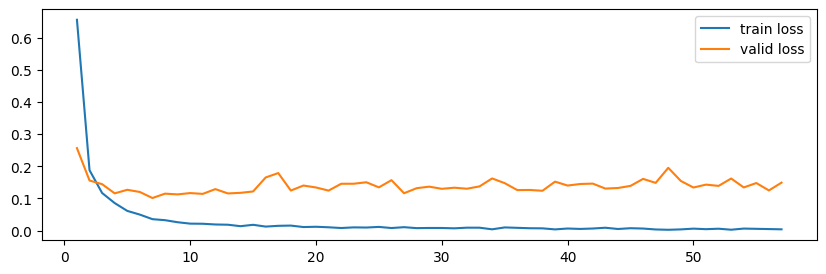

In [60]:
plt.figure(figsize=(10, 3))

# 훈련용 손실
plt.plot(range(1,len(train_history)+1), # x축데이터 (epoch)
         train_history, # y축데이터 (loss)
         label='train loss')

# 검증용 손실
plt.plot(range(1,len(valid_history)+1), # x축데이터 (epoch)
         valid_history, # y축데이터 (loss)
         label='valid loss')
# 범례
plt.legend()
plt.show()

- 혼돈행렬 확인

In [62]:
# 예측
model1.eval()

with torch.no_grad() :
    predictions = model1(X_test)

In [76]:
y_pred = predictions.argmax(dim = 1)

In [83]:
# 현재 데이터는 gpu ram 존재, numpy는 cpu 메모리 공간을 사용하게끔 기본 세팅
y_pred = y_pred.cpu().numpy()
y_test = y_test.cpu().numpy()

In [87]:
cm = confusion_matrix(y_test, y_pred)
pd.DataFrame(
    cm,
    index = [f"true_{i}" for i in range(output_size)],   # 실제 클래스
    columns = [f"pred_{i}" for i in range(output_size)]) # 예측 클래스

,pred_0,pred_1,pred_2,pred_3,pred_4,pred_5,pred_6,pred_7,pred_8,pred_9
true_0,968,2,2,0,0,1,2,1,3,1
true_1,0,1124,5,0,0,0,2,0,4,0
true_2,3,2,1009,4,2,1,2,6,3,0
true_3,1,0,8,986,0,0,0,1,7,7
true_4,1,0,2,0,966,0,3,3,0,7
true_5,5,0,0,17,0,850,4,0,10,6
true_6,5,2,1,1,10,3,931,0,5,0
true_7,2,3,7,5,3,0,0,999,2,7
true_8,5,0,3,3,4,1,1,2,952,3
true_9,5,2,2,2,21,0,0,7,5,965
